In [ ]:
!pip -q install praw tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 1.3 MB/s eta 0:00:00


In [ ]:
import os, logging
logging.getLogger("praw").setLevel(logging.ERROR)  # silence PRAW warnings

REDDIT_CLIENT_ID = "6GWJvIKbZCV9BhJjbA9zaQ"
REDDIT_CLIENT_SECRET = "KYDeZrfQJYNKFzYWgONuRvB3khWucw"
REDDIT_USER_AGENT = "msc-project-scraper:v1.0 (by u/Lazy_Buyer_7696)"

os.environ["REDDIT_CLIENT_ID"] = REDDIT_CLIENT_ID
os.environ["REDDIT_CLIENT_SECRET"] = REDDIT_CLIENT_SECRET
os.environ["REDDIT_USER_AGENT"] = REDDIT_USER_AGENT

In [ ]:
import os, json
from typing import Optional, List, Dict, Any
import praw
from tqdm import tqdm

IMG_EXT = (".jpg", ".jpeg", ".png", ".gif")

def mk_reddit():
    cid = os.environ.get("REDDIT_CLIENT_ID")
    csec = os.environ.get("REDDIT_CLIENT_SECRET")
    ua = os.environ.get("REDDIT_USER_AGENT", "msc-project-scraper:v1.0")
    if not cid or not csec:
        raise RuntimeError("Missing REDDIT_CLIENT_ID/REDDIT_CLIENT_SECRET.")
    return praw.Reddit(client_id=cid, client_secret=csec, user_agent=ua)

def clean_url(u: Optional[str]) -> Optional[str]:
    return None if not u else u.replace("&amp;", "&")

def infer_type(post) -> str:
    if getattr(post, "is_self", False):
        return "text"
    url = (post.url or "").lower()
    if getattr(post, "post_hint", "") == "image" or url.endswith(IMG_EXT):
        return "text+image" if (post.selftext or "").strip() else "image"
    if getattr(post, "is_gallery", False):
        return "text+image" if (post.selftext or "").strip() else "image"
    return "text+image" if (post.selftext or "").strip() else "link"

def extract_image_urls(post) -> List[str]:
    urls = []
    if post.url and post.url.lower().endswith(IMG_EXT):
        urls.append(clean_url(post.url))
    try:
        if post.preview and "images" in post.preview:
            for im in post.preview["images"]:
                src = im.get("source", {}).get("url")
                if src: urls.append(clean_url(src))
    except Exception:
        pass
    try:
        if getattr(post, "is_gallery", False) and getattr(post, "gallery_data", None):
            items = post.gallery_data.get("items", [])
            media_metadata = getattr(post, "media_metadata", {}) or {}
            for it in items:
                mid = it.get("media_id")
                meta = media_metadata.get(mid, {})
                if "s" in meta and "u" in meta["s"]:
                    urls.append(clean_url(meta["s"]["u"]))
    except Exception:
        pass
    # dedupe
    out, seen = [], set()
    for u in urls:
        if u and u not in seen:
            seen.add(u); out.append(u)
    return out

def to_record(post) -> Dict[str, Any]:
    ptype = infer_type(post)
    images = extract_image_urls(post) if ("image" in ptype) else []
    return {
        "platform": "reddit",
        "subreddit": str(post.subreddit),
        "type": ptype,  # "text" | "image" | "text+image" | "link"
        "id": post.id,
        "title": post.title or "",
        "body": post.selftext or "",
        "urls": {
            "post": clean_url(f"https://www.reddit.com{post.permalink}") if getattr(post, "permalink", None) else None,
            "external": clean_url(post.url) if post.url else None,
            "images": images,
        },
        "created_utc": int(post.created_utc),
        "score": post.score,
        "upvote_ratio": getattr(post, "upvote_ratio", None),
        "num_comments": post.num_comments,
        "author": str(post.author) if post.author else None,
        "over_18": bool(getattr(post, "over_18", False)),
        "spoiler": bool(getattr(post, "spoiler", False)),
        "emotion_label": None,
        "modality": "text" if ptype == "text" else ("image" if ptype == "image" else "text+image"),
        "source_meta": {
            "is_self": bool(getattr(post, "is_self", False)),
            "is_gallery": bool(getattr(post, "is_gallery", False)),
            "link_flair_text": getattr(post, "link_flair_text", None),
        },
        "comments_top": []  # off for speed
    }

def iter_subreddit_fast(reddit, name: str, limit: int):
    # Just grab the newest N posts and stop
    for post in reddit.subreddit(name).new(limit=limit):
        yield post

def scrape_fast(subreddits, out_path, per_sub_limit=250, nsfw=False):
    reddit = mk_reddit()
    totals = {}
    with open(out_path, "w", encoding="utf-8") as f:
        for sub in subreddits:
            count = 0
            for post in tqdm(iter_subreddit_fast(reddit, sub, per_sub_limit), desc=f"r/{sub}"):
                if not nsfw and getattr(post, "over_18", False):
                    continue
                rec = to_record(post)
                f.write(json.dumps(rec, ensure_ascii=False) + "\n")
                count += 1
            totals[sub] = count
    return totals

In [ ]:
subs = ["offmychest","relationships","wholesomememes","memes"]  # change if you want
totals = scrape_fast(subs, out_path="reddit_quick_1k.jsonl", per_sub_limit=250, nsfw=False)
totals

r/offmychest: 250it [01:35,  2.61it/s]
r/relationships: 250it [02:08,  1.95it/s]
r/wholesomememes: 250it [02:36,  1.60it/s]
r/memes: 250it [02:21,  1.77it/s]


{'offmychest': 224, 'relationships': 248, 'wholesomememes': 250, 'memes': 244}

In [ ]:
import json, itertools, collections

path = "reddit_quick_1k.jsonl"

# Show a few examples
with open(path, "r", encoding="utf-8") as f:
    for line in itertools.islice(f, 3):
        rec = json.loads(line)
        print(rec["subreddit"], rec["type"], "—", rec["title"][:100], "| images:", len(rec["urls"]["images"]))

# Counts per subreddit + modality
counts_sub = collections.Counter()
counts_mod = collections.Counter()
with open(path, "r", encoding="utf-8") as f:
    for line in f:
        rec = json.loads(line)
        counts_sub[rec["subreddit"]] += 1
        counts_mod[rec["modality"]] += 1

print("\nCounts per subreddit:", dict(counts_sub))
print("Counts per modality:", dict(counts_mod))
print("Total rows:", sum(counts_sub.values()))

offmychest text — Big booty Instagram "models" have taken over my life. I need help | images: 0
offmychest text — Cats and those who don't like them | images: 0
offmychest text — Narcissism and Toxicity | images: 0

Counts per subreddit: {'offmychest': 224, 'relationships': 248, 'wholesomememes': 250, 'memes': 244}
Counts per modality: {'text': 478, 'image': 450, 'text+image': 38}
Total rows: 966


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp reddit_quick_1k.jsonl /content/drive/MyDrive/reddit_quick_1k.jsonl
print("Saved to /content/drive/MyDrive/reddit_quick_1k.jsonl")

Mounted at /content/drive
Saved to /content/drive/MyDrive/reddit_quick_1k.jsonl


In [ ]:
import json

file_path = "/content/drive/MyDrive/reddit_quick_1k.jsonl"

try:
    with open(file_path, "r", encoding="utf-8") as f:
        first_line = f.readline()
        if first_line:
            rec = json.loads(first_line)
            print("Header (keys in the first record):")
            for key in rec.keys():
                print(f"- {key}")
        else:
            print(f"The file '{file_path}' is empty.")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from the first line of '{file_path}'.")

Header (keys in the first record):
- platform
- subreddit
- type
- id
- title
- body
- urls
- created_utc
- score
- upvote_ratio
- num_comments
- author
- over_18
- spoiler
- emotion_label
- modality
- source_meta
- comments_top


In [ ]:
import json, itertools

file_path = "/content/drive/MyDrive/reddit_quick_1k.jsonl"

try:
    with open(file_path, "r", encoding="utf-8") as f:
        print("First 5 rows:")
        for i, line in enumerate(itertools.islice(f, 5)):
            # Assuming each line is a valid JSON object
            rec = json.loads(line)
            print(f"Row {i+1}: {json.dumps(rec, indent=2)}")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except json.JSONDecodeError as e:
    print(f"Error: Could not decode JSON from line {i+1} of '{file_path}': {e}")

First 5 rows:
Row 1: {
  "platform": "reddit",
  "subreddit": "offmychest",
  "type": "text",
  "id": "1n8cxl5",
  "title": "Big booty Instagram \"models\" have taken over my life. I need help",
  "body": "I was gonna post this on a anonymous account but nobody knows what I look like plus it's not that bad of confession I think. But anyways my life is dominated by these big booty IG girls and it's hurting my chances to get a gf. From the moment I wake up to the moment I sleep my mind and eyes are glued to my Instagram account when I follow only big booty IG models. I've sent some of the money even when I'm on my bottom dollar. I sneak and watch them even at work and people have actually even caught me looking at big booty IG models on my phone In public. I admit that I've become addicted and I continuously follow more and more big booty IG women. It's not just a confession sion, I really need advice too please.",
  "urls": {
    "post": "https://www.reddit.com/r/offmychest/comments/1n8

In [ ]:
import json, re, pandas as pd

in_path = "reddit_quick_1k.jsonl"
out_path = "reddit_quick_1k_FOR_EXCEL.csv"

# Simple emoji extractor
EMOJI_PATTERN = re.compile(
    "["
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F680-\U0001F6FF"  # transport & map
    "\U0001F700-\U0001F77F"  # alchemical
    "\U0001F780-\U0001F7FF"  # geometric
    "\U0001F800-\U0001F8FF"  # arrows
    "\U0001F900-\U0001F9FF"  # supplemental symbols & pictographs
    "\U0001FA00-\U0001FA6F"  # chess etc.
    "\U0001FA70-\U0001FAFF"  # emojis extended
    "\u2600-\u26FF"          # misc symbols
    "\u2700-\u27BF"          # dingbats
    "]+"
)

def extract_emojis(s: str) -> str:
    if not s: return ""
    return "".join(EMOJI_PATTERN.findall(s))

def map_modality(rec_type: str, body: str) -> str:
    rec_type = (rec_type or "").lower()
    body = (body or "").strip()
    if rec_type == "text":
        return "Text-only"
    if rec_type == "image":
        return "Image-only"
    if rec_type == "text+image":
        return "Text+Image"
    return "Text+Image" if body else "Text-only"

rows = []
with open(in_path, "r", encoding="utf-8") as f:
    for line in f:
        rec = json.loads(line)
        title = (rec.get("title") or "").strip()
        body = (rec.get("body") or "").strip()
        text = (title + ("\n\n" + body if body else "")).strip()
        images = rec.get("urls", {}).get("images", []) or []
        image_ref = ";".join(images)
        modality = map_modality(rec.get("type"), body)

        rows.append({
            "Text": text if text else None,
            "Emotion_Label": None,  # fill later during annotation
            "Emoji": extract_emojis(text),
            "Image_Reference": image_ref if image_ref else None,
            "Subcommunity_Tag": rec.get("subreddit"),
            "Modality_Type": modality,
            "Social_Media_Type": "Reddit",
            "Source": rec.get("urls", {}).get("post"),
        })

df = pd.DataFrame(rows, columns=[
    "Text","Emotion_Label","Emoji","Image_Reference",
    "Subcommunity_Tag","Modality_Type","Social_Media_Type","Source"
])

df.to_csv(out_path, index=False, encoding="utf-8")
print(f"Saved {len(df)} rows to {out_path}")

Saved 966 rows to reddit_quick_1k_FOR_EXCEL.csv


In [ ]:
import pandas as pd
import numpy as np
import re

# Locate Dataset Paths:
twitter_path = "/content/drive/MyDrive/Text to Emotion - Dataset Schema - Sheet1.csv"   # (Twitter)
reddit_path  = "/content/reddit_quick_1k_FOR_EXCEL.csv"                   # (Reddit)
out_merged   = "combined_twitter_reddit.csv"

# Set Column Target:
TARGET = ["Text","Emotion_Label","Emoji","Image_Reference",
          "Subcommunity_Tag","Modality_Type","Social_Media_Type","Source"]

def load_and_normalize(path, platform_hint=None):
    df = pd.read_csv(path)

    # Drop obvious index cols
    drop_cols = [c for c in df.columns if c.lower().startswith("unnamed")]
    if drop_cols:
        df = df.drop(columns=drop_cols, errors="ignore")

    # Check target columns exist
    for c in TARGET:
        if c not in df.columns:
            df[c] = np.nan

    df = df[TARGET]

    # Cut whitespace in data
    for c in ["Text","Emoji","Image_Reference","Subcommunity_Tag","Modality_Type","Social_Media_Type","Source"]:
        df[c] = df[c].astype(str).replace({"nan": np.nan})
        df[c] = df[c].apply(lambda x: x.strip() if isinstance(x,str) else x)

    # Normalize Modality_Type values
    def norm_modality(x):
        if not isinstance(x,str): return np.nan
        xl = x.lower()
        if "text+image" in xl: return "Text+Image"
        if "image-only" in xl or xl == "image": return "Image-only"
        if "text-only" in xl or xl == "text": return "Text-only"
        # Fallback
        return "Text-only" if xl in ["", "nan", "none"] else x
    df["Modality_Type"] = df["Modality_Type"].apply(norm_modality)

    # Fix Social_Media_Type
    if platform_hint:
        df["Social_Media_Type"] = platform_hint
    else:
        # Some rows had "All" in your sample; make those "Twitter"
        df.loc[df["Social_Media_Type"].isin([None, "", "nan", "All"]), "Social_Media_Type"] = "Twitter"

    # Drop empty rows (the posts with no text and no images)
    df = df[~(df["Text"].isna() & df["Image_Reference"].isna())].copy()

    # Replace empty strings to NaN
    df.replace({"": np.nan, "nan": np.nan}, inplace=True)

    return df

tw = load_and_normalize(twitter_path, platform_hint="Twitter")
rd = load_and_normalize(reddit_path,  platform_hint="Reddit")

# Concatenate data
combined = pd.concat([tw, rd], ignore_index=True)

# Define a normalized key: Text (lower + collapse spaces) + first image URL + Source
def norm_text(s):
    if not isinstance(s,str): return ""
    s = s.lower().strip()
    s = re.sub(r"\s+", " ", s)
    return s

# Extract the first image url token for dedupe
def first_image(s):
    if not isinstance(s,str): return ""
    return s.split(";")[0].strip()

key = (
    combined["Text"].apply(norm_text) + " | " +
    combined["Image_Reference"].apply(first_image) + " | " +
    combined["Source"].fillna("")
)

combined["__dedupe_key"] = key
before = len(combined)
combined = combined.drop_duplicates(subset="__dedupe_key").drop(columns="__dedupe_key")
after = len(combined)

print(f"Deduped: {before - after} duplicates removed; final rows = {after}")

# !! Save merged (new combined dataset)
combined.to_csv(out_merged, index=False, encoding="utf-8")
print(f"Saved merged dataset to {out_merged}")

Deduped: 78 duplicates removed; final rows = 28666
Saved merged dataset to combined_twitter_reddit.csv


Check Columns and Statistics of combined dataset (Twitter+Reddit)

In [ ]:
import pandas as pd

df = pd.read_csv("combined_twitter_reddit.csv")

print("Rows:", len(df))
print("\nBy platform:")
print(df["Social_Media_Type"].value_counts(dropna=False))

print("\nBy modality:")
print(df["Modality_Type"].value_counts(dropna=False))

print("\nTop subcommunities (Reddit only):")
top_subs = df.loc[df["Social_Media_Type"]=="Reddit","Subcommunity_Tag"].value_counts().head(10)
print(top_subs)

Rows: 28666

By platform:
Social_Media_Type
Twitter    27700
Reddit       966
Name: count, dtype: int64

By modality:
Modality_Type
NaN             27533
Text-only         556
Image-only        476
Text+Image         97
Text + Image        2
Text Only           2
Name: count, dtype: int64

Top subcommunities (Reddit only):
Subcommunity_Tag
wholesomememes    250
relationships     248
memes             244
offmychest        224
Name: count, dtype: int64


In [ ]:
with pd.ExcelWriter("combined_twitter_reddit.xlsx") as xw:
    df = pd.read_csv("combined_twitter_reddit.csv")
    df.to_excel(xw, index=False, sheet_name="data")

    # Summary sheets
    df["count"] = 1
    plat = df.pivot_table(index="Social_Media_Type", values="count", aggfunc="sum").reset_index()
    mod  = df.pivot_table(index="Modality_Type",     values="count", aggfunc="sum").reset_index()
    subs = df[df["Social_Media_Type"]=="Reddit"].pivot_table(index="Subcommunity_Tag", values="count", aggfunc="sum").reset_index().sort_values("count", ascending=False)

    plat.to_excel(xw, index=False, sheet_name="by_platform")
    mod.to_excel(xw, index=False, sheet_name="by_modality")
    subs.to_excel(xw, index=False, sheet_name="reddit_subs")
print("Wrote combined_twitter_reddit.xlsx")

Wrote combined_twitter_reddit.xlsx


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive | grep combined

combined_twitter_reddit.gsheet


In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/combined_twitter_reddit.csv")
df.head()

,Text,Emotion_Label,Emoji,Image_Reference,Subcommunity_Tag,Modality_Type,Social_Media_Type,Source
0,"""No one gets me like she does...""",Love,❤️,NaN,gen_z_romance,Text-only,Twitter,NaN
1,"""IT'S MONDAY AGAIN!""",Disgust,😩,NaN,gen_z_relate,Text+Image,Twitter,NaN
2,"""Letting someone hold your phone while it’s un...",Trust,NaN,NaN,gen_z_friendship,Text-only,Twitter,https://x.com/TheAblebaee/status/1362314228217...
3,“When your laptop fans start sounding like a j...,Fear,NaN,NaN,gen_z_academia,Text-only,Twitter,NaN
4,"""That moment when your playlist hits every vib...",Joy,🔥,NaN,gen_z_gamers,Text-only,Twitter,NaN


Fixing reddit image links (broken) :

In [ ]:
in_path  = "/content/drive/MyDrive/combined_twitter_reddit.csv"
out_path = "/content/drive/MyDrive/combined_twitter_reddit_CLEANED.csv"

In [ ]:
!pip -q install pandas

In [ ]:
import pandas as pd
from urllib.parse import unquote, urlparse, parse_qs
import numpy as np

PREFERRED_DOMAINS = {"i.redd.it", "preview.redd.it", "i.imgur.com", "imgur.com"}
IMG_EXT = (".jpg",".jpeg",".png",".gif",".webp",".bmp",".tiff")

def is_img_url(u: str) -> bool:
    if not isinstance(u, str): return False
    ul = u.lower()
    return ul.endswith(IMG_EXT) or ("i.redd.it" in ul) or ("preview.redd.it" in ul)

def unwrap_candidate(url: str):
    """Handle reddit.com/media?url=... and semicolon-separated lists."""
    if not isinstance(url, str) or not url.strip():
        return []
    url = unquote(url).replace("&amp;", "&")
    parts = [p.strip() for p in url.split(";") if p.strip()]
    outs = []
    for p in parts:
        if "reddit.com/media?url=" in p:
            try:
                q = parse_qs(urlparse(p).query).get("url", [])
                outs += [unquote(x).replace("&amp;","&") for x in q]
            except Exception:
                pass
        else:
            outs.append(p)
    return outs

def clean_image_ref(cell: str) -> str:
    """Return up to 3 real image URLs, preferring i.redd.it/preview.redd.it/imgur."""
    if not isinstance(cell, str) or not cell.strip():
        return ""
    # unwrap and gather candidates
    candidates = []
    for token in cell.split(";"):
        candidates.extend(unwrap_candidate(token))

    seen, dedup = set(), []
    for c in candidates:
        if c and c not in seen:
            seen.add(c); dedup.append(c)

    # score URLs: prefer direct image hosts + real image endings; penalize wrappers
    def score(u):
        host = urlparse(u).netloc.lower()
        s = 0
        if host in PREFERRED_DOMAINS: s += 5
        if is_img_url(u): s += 5
        if "reddit.com/media" in u: s -= 10
        return -s

    dedup.sort(key=score)
    good = [u for u in dedup if is_img_url(u)]
    keep = good[:3] if good else dedup[:1]
    return ";".join(keep)

#  Load combinedcsv
df = pd.read_csv(in_path)

# Normalize Social_Media_Type to be safe
df["Social_Media_Type"] = df["Social_Media_Type"].astype(str).str.strip()

# Stats before
mask_reddit = df["Social_Media_Type"].str.lower().eq("reddit")
before_nonempty = df.loc[mask_reddit, "Image_Reference"].notna().sum()

# Clean ONLY Reddit rows
df.loc[mask_reddit, "Image_Reference"] = df.loc[mask_reddit, "Image_Reference"].apply(clean_image_ref)

# Replace empty strings with NaN
df["Image_Reference"] = df["Image_Reference"].replace({"": np.nan})

after_nonempty = df.loc[mask_reddit, "Image_Reference"].notna().sum()
print(f"Reddit rows with image refs (before → after): {before_nonempty} → {after_nonempty}")

# Save cleaned combined file
df.to_csv(out_path, index=False, encoding="utf-8")
print(f"Saved cleaned combined dataset → {out_path}")

Reddit rows with image refs (before → after): 476 → 476
Saved cleaned combined dataset → /content/drive/MyDrive/combined_twitter_reddit_CLEANED.csv


In [ ]:
sample = df[mask_reddit & df["Image_Reference"].notna()].head(8)
sample[["Subcommunity_Tag","Text","Image_Reference"]]

,Subcommunity_Tag,Text,Image_Reference
28173,wholesomememes,Surprise Mother! (oc),https://i.redd.it/2tfue5w4xnmf1.jpeg;https://p...
28174,wholesomememes,cute honey bee (oc),https://i.redd.it/lddimzp35ulf1.jpeg;https://p...
28175,wholesomememes,"Always on my mind, twin (oc)",https://i.redd.it/awbb3usfrsjf1.jpeg;https://p...
28176,wholesomememes,Better to have loved and lost ❤️ [OC],https://i.redd.it/n28z5er70rjf1.jpeg;https://p...
28177,wholesomememes,"It may not seem like much at first, but it all...",https://i.redd.it/okjoujh6uajf1.jpeg;https://p...
28178,wholesomememes,Be Kind to Those Around You [OC],https://i.redd.it/aka8zokx08gf1.jpeg;https://p...
28179,wholesomememes,Sometimes a little air does wonders to my mood...,https://i.redd.it/6rcglxli59gf1.jpeg;https://p...
28180,wholesomememes,ok thank you (oc),https://i.redd.it/ee0zl1ekpgff1.jpeg;https://p...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

in_path  = "/content/drive/MyDrive/combined_twitter_reddit_CLEANED.csv"
out_path = "/content/drive/MyDrive/combined_twitter_reddit_PREVIEW.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv(in_path)

def keep_preview_only(cell: str) -> str:
    if not isinstance(cell, str) or not cell.strip():
        return cell
    parts = [p.strip() for p in cell.split(";") if p.strip()]
    has_i = any("i.redd.it" in p.lower() for p in parts)
    has_preview = any("preview.redd.it" in p.lower() for p in parts)
    # Only modify rows that have BOTH types
    if has_i and has_preview:
        previews = [u for u in parts if "preview.redd.it" in u.lower()]
        return ";".join(previews) if previews else cell
    return cell

mask = df["Image_Reference"].astype(str).str.contains("i.redd.it", case=False, na=False) & \
       df["Image_Reference"].astype(str).str.contains("preview.redd.it", case=False, na=False)

changed_before = mask.sum()
df.loc[mask, "Image_Reference"] = df.loc[mask, "Image_Reference"].apply(keep_preview_only)
df["Image_Reference"] = df["Image_Reference"].replace({"": np.nan})

print(f"Rows with both i.redd.it + preview.redd.it BEFORE change: {changed_before}")
print(f"Rows still matching both after change: { (df['Image_Reference'].astype(str).str.contains('i.redd.it', case=False, na=False) & df['Image_Reference'].astype(str).str.contains('preview.redd.it', case=False, na=False)).sum() }")

df.to_csv(out_path, index=False, encoding="utf-8")
print(f"Saved → {out_path}")

Rows with both i.redd.it + preview.redd.it BEFORE change: 476
Rows still matching both after change: 0
Saved → /content/drive/MyDrive/combined_twitter_reddit_PREVIEW.csv


In [ ]:
sample = df[df["Image_Reference"].astype(str).str.contains("preview.redd.it", case=False, na=False)].head(10)
sample[["Subcommunity_Tag","Image_Reference"]]

,Subcommunity_Tag,Image_Reference
28173,wholesomememes,https://preview.redd.it/2tfue5w4xnmf1.jpeg?aut...
28174,wholesomememes,https://preview.redd.it/lddimzp35ulf1.jpeg?aut...
28175,wholesomememes,https://preview.redd.it/awbb3usfrsjf1.jpeg?aut...
28176,wholesomememes,https://preview.redd.it/n28z5er70rjf1.jpeg?aut...
28177,wholesomememes,https://preview.redd.it/okjoujh6uajf1.jpeg?aut...
28178,wholesomememes,https://preview.redd.it/aka8zokx08gf1.jpeg?aut...
28179,wholesomememes,https://preview.redd.it/6rcglxli59gf1.jpeg?aut...
28180,wholesomememes,https://preview.redd.it/ee0zl1ekpgff1.jpeg?aut...
28181,wholesomememes,https://preview.redd.it/ozd32csuf0ff1.jpeg?aut...
28182,wholesomememes,https://preview.redd.it/ipvet14grhef1.jpeg?aut...


Extracting images / downloading all memes:

In [ ]:
# INPUT the combined CSV (the one with Image_Reference URLs)
IN_CSV  = "/content/drive/MyDrive/combined_twitter_reddit_PREVIEW.csv"
# OUTPUTS
OUT_DIR = "/content/drive/MyDrive/dataset_images"
MANIFEST_CSV = "/content/drive/MyDrive/image_manifest.csv"
UPDATED_CSV  = "/content/drive/MyDrive/combined_with_local_images.csv"  # dataset + local paths

In [ ]:
!pip -q install pandas tqdm pillow requests

In [ ]:
import os, re, hashlib, mimetypes, time
from urllib.parse import urlparse, unquote
import pandas as pd
import requests
from tqdm import tqdm

# Make output dir
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(IN_CSV)

# Normalize column names
if "Image_Reference" not in df.columns:
    raise ValueError("Expected 'Image_Reference' column in your CSV")

IMG_EXT = (".jpg",".jpeg",".png",".gif",".webp",".bmp",".tiff")
PREFERRED_DOMAIN_ORDER = ["preview.redd.it", "i.redd.it", "i.imgur.com", "imgur.com"]

def split_urls(cell):
    if not isinstance(cell, str) or not cell.strip():
        return []
    return [u.strip() for u in cell.split(";") if u.strip()]

def prefer_preview(urls):
    """If both preview.redd.it and i.redd.it exist, keep preview first."""
    if not urls: return urls
    # Stable sort by preferred domain order
    def score(u):
        host = urlparse(u).netloc.lower()
        for i, dom in enumerate(PREFERRED_DOMAIN_ORDER):
            if dom in host:
                return i
        return len(PREFERRED_DOMAIN_ORDER) + 1
    return sorted(urls, key=score)

def pick_ext_from_headers(ct):
    if not ct:
        return None
    ct = ct.lower().split(";")[0]
    # common special-cases
    mapping = {
        "image/jpeg": ".jpg",
        "image/jpg":  ".jpg",
        "image/png":  ".png",
        "image/gif":  ".gif",
        "image/webp": ".webp",
        "image/bmp":  ".bmp",
        "image/tiff": ".tiff",
    }
    return mapping.get(ct, mimetypes.guess_extension(ct) or None)

def safe_name_from_url(url):
    """
    Hash-based filename to avoid duplicates/invalid chars.
    Preserve an extension if present, else fill by content-type later.
    """
    parsed = urlparse(url)
    path = unquote(parsed.path)
    base = os.path.basename(path)
    # get ext if any
    ext = ""
    for e in IMG_EXT:
        if base.lower().endswith(e):
            ext = e
            break
    # stable hash
    h = hashlib.sha1(url.encode("utf-8")).hexdigest()[:16]
    return h, ext

def fetch(url, dest_no_ext, given_ext, session, timeout=20, retries=2):
    """
    Download URL to dest path. If given_ext empty, infer from content-type.
    Returns (final_path, status) where status in {"ok","skipped","error"}.
    """
    try:
        r = session.get(url, stream=True, timeout=timeout, allow_redirects=True)
        ct = r.headers.get("Content-Type", "")
        if r.status_code != 200 or (ct and not ct.lower().startswith("image/")):
            # not an image; skip
            return None, f"error({r.status_code} {ct})"
        ext = given_ext or pick_ext_from_headers(ct) or ".jpg"
        dest = dest_no_ext + ext
        # skip if already exists
        if os.path.exists(dest) and os.path.getsize(dest) > 0:
            return dest, "skipped"
        # write
        with open(dest, "wb") as f:
            for chunk in r.iter_content(1024 * 64):
                if chunk:
                    f.write(chunk)
        return dest, "ok"
    except requests.exceptions.RequestException as e:
        if retries > 0:
            time.sleep(1.0)
            return fetch(url, dest_no_ext, given_ext, session, timeout, retries-1)
        return None, f"error({type(e).__name__})"

# Build a flat list of (row_idx, url)
pairs = []
seen_url = set()
for idx, cell in enumerate(df["Image_Reference"].astype(str).tolist()):
    urls = split_urls(cell)
    if not urls:
        continue
    urls = prefer_preview(urls)
    for u in urls:
        if u and u not in seen_url:
            seen_url.add(u)
            pairs.append((idx, u))

print(f"Total unique image URLs to fetch: {len(pairs)}")

# Download loop
session = requests.Session()
manifest_rows = []
for row_idx, url in tqdm(pairs, desc="Downloading images"):
    h, ext = safe_name_from_url(url)
    dest_no_ext = os.path.join(OUT_DIR, h)
    final_path, status = fetch(url, dest_no_ext, ext, session)
    manifest_rows.append({
        "row_index": row_idx,
        "url": url,
        "local_path": final_path,
        "status": status
    })

manifest = pd.DataFrame(manifest_rows)
manifest.to_csv(MANIFEST_CSV, index=False)
print(f"Manifest saved → {MANIFEST_CSV}")

# Merge local image paths back into dataset
# Build a semicolon-joined local path column for rows that had multiple URLs
paths_by_row = {}
for r in manifest_rows:
    if r["status"].startswith("error"):
        continue
    if r["local_path"] is None:
        continue
    paths_by_row.setdefault(r["row_index"], []).append(r["local_path"])

local_paths_col = []
for i in range(len(df)):
    paths = paths_by_row.get(i, [])
    local_paths_col.append(";".join(paths) if paths else None)

df["Image_Local_Path"] = local_paths_col
df.to_csv(UPDATED_CSV, index=False)
print(f"Updated dataset with local paths → {UPDATED_CSV}")

# Quick summary to CHECK
print("\nDownload summary:")
print(manifest["status"].value_counts())

Total unique image URLs to fetch: 574


Manifest saved → /content/drive/MyDrive/image_manifest.csv
Updated dataset with local paths → /content/drive/MyDrive/combined_with_local_images.csv

Download summary:
status
ok                                     462
error(MissingSchema)                    97
error(404 image/png)                    14
error(200 text/html; charset=utf-8)      1
Name: count, dtype: int64


In [ ]:
IN_CSV       = "/content/drive/MyDrive/combined_with_local_images.csv"   # from your last step
MANIFEST_IN  = "/content/drive/MyDrive/image_manifest.csv"
OUT_DIR      = "/content/drive/MyDrive/dataset_images"
MANIFEST_OUT = "/content/drive/MyDrive/image_manifest_fixed.csv"
UPDATED_OUT  = "/content/drive/MyDrive/combined_with_local_images_FIXED.csv"

In [ ]:
!pip -q install pandas requests tqdm

In [ ]:
import os, re, hashlib, mimetypes, time
from urllib.parse import urlparse, parse_qs, unquote
import pandas as pd, requests
from tqdm import tqdm

os.makedirs(OUT_DIR, exist_ok=True)

IMG_EXT = (".jpg",".jpeg",".png",".gif",".webp",".bmp",".tiff")

def pick_ext_from_headers(ct):
    if not ct: return None
    ct = ct.lower().split(";")[0]
    mapping = {
        "image/jpeg": ".jpg", "image/jpg": ".jpg",
        "image/png": ".png", "image/gif": ".gif",
        "image/webp": ".webp", "image/bmp": ".bmp",
        "image/tiff": ".tiff",
    }
    return mapping.get(ct, mimetypes.guess_extension(ct) or None)

def hash_name(url):
    return hashlib.sha1(url.encode("utf-8")).hexdigest()[:16]

def normalize_url(u):
    """Fix common problems: missing scheme, reddit media wrapper, imgur page URLs."""
    if not isinstance(u, str) or not u.strip():
        return None
    u = unquote(u).replace("&amp;","&").strip()

    # missing schema -> add https
    if u.startswith("//"):
        u = "https:" + u
    elif not u.startswith("http://") and not u.startswith("https://"):
        u = "https://" + u

    # unwrap reddit media wrapper
    if "reddit.com/media?url=" in u:
        try:
            q = parse_qs(urlparse(u).query)
            inner = q.get("url", [])
            if inner:
                u = unquote(inner[0]).replace("&amp;","&")
        except Exception:
            pass

    # imgur page -> convert to direct
    pu = urlparse(u)
    host = pu.netloc.lower()
    path = pu.path

    # if plain imgur page like imgur.com/abc -> i.imgur.com/abc.jpg
    if "imgur.com" in host and "i.imgur.com" not in host:
        # ignore album/gallery which is tricky
        if path and ("/a/" not in path and "/gallery/" not in path):
            id_ = path.rsplit("/", 1)[-1]
            # if id already has an extension, keep it; else default to .jpg
            if not any(id_.lower().endswith(e) for e in IMG_EXT):
                id_ = id_ + ".jpg"
            u = f"https://i.imgur.com/{id_}"

    return u

def fetch(url, session, given_ext=""):
    try:
        r = session.get(url, stream=True, timeout=20, allow_redirects=True)
        ct = (r.headers.get("Content-Type") or "").lower()
        if r.status_code != 200 or not ct.startswith("image/"):
            return None, f"error({r.status_code} {ct or ''})"
        ext = given_ext or pick_ext_from_headers(ct) or ".jpg"
        dest = os.path.join(OUT_DIR, hash_name(url) + ext)
        if os.path.exists(dest) and os.path.getsize(dest) > 0:
            return dest, "skipped"
        with open(dest, "wb") as f:
            for chunk in r.iter_content(1024 * 64):
                if chunk: f.write(chunk)
        return dest, "ok"
    except requests.exceptions.RequestException as e:
        return None, f"error({type(e).__name__})"

# Load current dataset + manifest
df = pd.read_csv(IN_CSV)
man = pd.read_csv(MANIFEST_IN)

# Find failures
fail = man[man["status"].str.startswith("error", na=False)].copy()
print("Failures to retry:", len(fail))

session = requests.Session()
fixed_rows = []
for _, row in tqdm(fail.iterrows(), total=len(fail), desc="Retrying failed URLs"):
    idx = int(row["row_index"])
    raw = str(row["url"])
    u = normalize_url(raw)
    if not u:
        fixed_rows.append({"row_index": idx, "url": raw, "local_path": None, "status": "error(normalize)"})
        continue
    # try fetch
    path, status = fetch(u, session)
    fixed_rows.append({"row_index": idx, "url": u, "local_path": path, "status": status})

fixed = pd.DataFrame(fixed_rows)
fixed.to_csv(MANIFEST_OUT, index=False)
print(f"Saved retry manifest → {MANIFEST_OUT}")

# Merge successes back into dataset
ok_paths = fixed[fixed["status"]=="ok"].groupby("row_index")["local_path"].apply(list)

# Append new local paths to existing Image_Local_Path
local_paths = df.get("Image_Local_Path")
if local_paths is None:
    local_paths = pd.Series([None]*len(df))
else:
    local_paths = local_paths.astype(str).replace({"nan": None})

def merge_paths(existing, new_list):
    ex = None if existing in (None, "", "nan") else existing
    if not new_list: return ex
    new = ";".join(new_list)
    if not ex: return new
    # dedupe on ';'
    parts = [p for p in (ex.split(";")+new.split(";")) if p]
    seen, out = set(), []
    for p in parts:
        if p not in seen:
            seen.add(p); out.append(p)
    return ";".join(out)

for idx, paths in ok_paths.items():
    df.at[idx, "Image_Local_Path"] = merge_paths(local_paths.iloc[idx] if idx < len(local_paths) else None, paths)

df.to_csv(UPDATED_OUT, index=False)
print(f"Updated dataset with extra recovered images → {UPDATED_OUT}")

print("\nRetry result breakdown:")
print(fixed["status"].value_counts())

Failures to retry: 112


Retrying failed URLs: 100%|██████████| 112/112 [00:03<00:00, 29.93it/s]


Saved retry manifest → /content/drive/MyDrive/image_manifest_fixed.csv
Updated dataset with extra recovered images → /content/drive/MyDrive/combined_with_local_images_FIXED.csv

Retry result breakdown:
status
error(ConnectionError)                 97
error(404 image/png)                   14
error(200 text/html; charset=utf-8)     1
Name: count, dtype: int64


In [ ]:
!ls -lh /content/drive/MyDrive/dataset_images | head -20

total 121M
-rw------- 1 root root  498K Sep  5 13:29 00ae1bb3dc3e6fc9.jpeg
-rw------- 1 root root  139K Sep  5 13:28 01c01fc068bf00aa.jpeg
-rw------- 1 root root  714K Sep  5 13:29 01c7fabe3a3e9812.png
-rw------- 1 root root   74K Sep  5 13:28 01fbe6cfaef7fad4.jpeg
-rw------- 1 root root  609K Sep  5 13:29 0243e7f418736340.png
-rw------- 1 root root   51K Sep  5 13:29 0258adde4ca91a9f.gif
-rw------- 1 root root   49K Sep  5 13:29 02a1dae7f6d0ad3e.jpeg
-rw------- 1 root root   79K Sep  5 13:29 02b5970e217aa663.png
-rw------- 1 root root  477K Sep  5 13:29 02e1bf44799c6cd2.jpeg
-rw------- 1 root root  297K Sep  5 13:29 0479576f57430dc3.png
-rw------- 1 root root  125K Sep  5 13:29 04ec9ff89e2d19e8.gif
-rw------- 1 root root   38K Sep  5 13:28 05e4c3541b250180.jpeg
-rw------- 1 root root  799K Sep  5 13:28 062dd09965df98bc.png
-rw------- 1 root root  124K Sep  5 13:29 065584845f72f35f.jpeg
-rw------- 1 root root   47K Sep  5 13:28 07044b45ef1cd501.jpeg
-rw------- 1 root root  298K Sep  5 

Check to see actual images have been extracted:

Showing: 00ae1bb3dc3e6fc9.jpeg


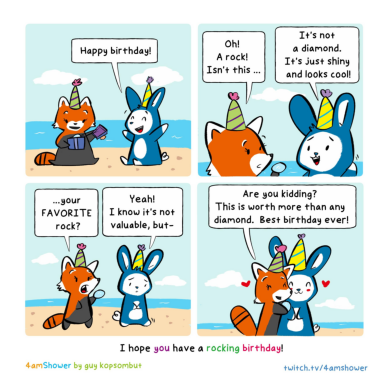

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = "/content/drive/MyDrive/dataset_images"

import os
first_file = sorted(os.listdir(img_path))[0]
print("Showing:", first_file)

img = mpimg.imread(os.path.join(img_path, first_file))
plt.imshow(img)
plt.axis("off")
plt.show()